In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Fit model with selected features 
features transformed, same as Sixuan's

In [10]:
#15 most impt features
features = ['log_kw_avg_avg', 'log_kw_max_avg', 'sqrt_self_reference_min_shares', 
                 'n_unique_tokens', 'log_LDA_03', 'log_LDA_04', 'log_LDA_00', 'log_LDA_02', 
                 'sqrt_num_hrefs', 'log_LDA_01', 'global_rate_positive_words', 'average_token_length', 
                 'global_sentiment_polarity', 'is_weekend', 'title_subjectivity']
target = 'class_N4'
seed = 2021
test_size = 0.2 

In [11]:
df= pd.read_csv('OnlineNewsPopularity.csv')
# N=4
df['class_N4'] = 0
df.loc[(df[' shares']>=1050) & (df[' shares']<2350), 'class_N4'] = 1
df.loc[(df[' shares']>=2350) & (df[' shares']<7550), 'class_N4'] = 2
df.loc[df[' shares']>=7550, 'class_N4'] = 3

In [12]:
#outlier (>1) in var “n_unique_tokens”, “n_non_stop_words”, and “n_non_stop_unique_tokens”, 
#which might be due to typing error. We will remove that observation.
col_list = [4,5,6]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]<1]

 n_unique_tokens
 n_non_stop_words
 n_non_stop_unique_tokens


In [13]:
#Missing values are very troubling in this data set because they are coded as 0. 
#So you have to judge if the 0 are missing or real data. By check the distributions, 
#we found around 3000 observations with missing values in 9 different variables. 
#We will remove all cases with missing values.
col_list = [11,20,44,45,46,48,49,50,53]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]!=0]

 average_token_length
 kw_max_min
 global_subjectivity
 global_sentiment_polarity
 global_rate_positive_words
 rate_positive_words
 rate_negative_words
 avg_positive_polarity
 avg_negative_polarity


In [14]:
#treat skewed data. 
#for those variables with all values bigger than 0, use log
#and other variable with 0, use square root.

col_list = [3,7,8,9,10,22,26,27,28,29,30,39,40,41,42,43,47,60] ######
for col in col_list:
    print(df.columns[col])
    if np.min(df[df.columns[col]]) > 0:
        col_name = 'log_'+df.columns[col]
        df[df.columns[col]] = np.log(df[df.columns[col]])
    else:
        col_name = 'sqrt_'+df.columns[col]
        df[df.columns[col]] = np.sqrt(df[df.columns[col]])   
    if df.columns[col] != ' shares':
        df.rename(columns={df.columns[col]:col_name}, inplace=True)


 n_tokens_content
 num_hrefs
 num_self_hrefs
 num_imgs
 num_videos
 kw_min_max
 kw_max_avg
 kw_avg_avg
 self_reference_min_shares
 self_reference_max_shares
 self_reference_avg_sharess
 LDA_00
 LDA_01
 LDA_02
 LDA_03
 LDA_04
 global_rate_negative_words
 shares


In [15]:
df.columns = df.columns.str.replace(' ', '')

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

df_X = df[features]
df_y = df[target]

X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_y,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=df_y)

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [17]:
X_train = X_train[features]
#on the test
#scaler = StandardScaler()
#X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
#X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
xgb_clf = xgb.XGBClassifier( objective= 'multi:softmax')
xgb_clf.fit(X_train, y_train )
y_pred = xgb_clf.predict(X_test[features])
y_true = y_test
print('roc auc score is {}'.format(roc_auc_score(y_true, xgb_clf.predict_proba(X_test[features]), multi_class='ovr')))
print('accuracy score is {}'.format(accuracy_score(y_true, y_pred)))
print(classification_report (y_true, y_pred))
#accuracy quite low, need to select features independently for the model

roc auc score is 0.6550279385949409
accuracy score is 0.4395589248793935
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      2252
           1       0.43      0.59      0.50      2829
           2       0.40      0.20      0.27      1599
           3       0.23      0.05      0.09       575

    accuracy                           0.44      7255
   macro avg       0.39      0.34      0.34      7255
weighted avg       0.42      0.44      0.41      7255



In [22]:
%%time
## fine tuning xgb gridsearch 
pipe_xgb = xgb.XGBClassifier(objective= 'multi:softmax',random_state=42)

params_xgb = [ 
  {'n_estimators': [200],
   'max_depth': [10], #10
   'learning_rate': [0.07, 0.1], #0.05
   #'subsample': [0.7,1],
   'min_child_weight': [20,50]
  }
]

grid_xgb = GridSearchCV(estimator=pipe_xgb,
                        param_grid=params_xgb,
                        scoring='accuracy',
                        cv=5)

grid_xgb.fit(X_train, y_train)

xgb_best_score = grid_xgb.best_score_
xgb_best_params = grid_xgb.best_params_
xgb_best_model = grid_xgb.best_estimator_

print("Best AUC:", round(xgb_best_score,2))
print("Best parameters:", xgb_best_params)

Best AUC: 0.44
Best parameters: {'learning_rate': 0.07, 'max_depth': 10, 'min_child_weight': 20, 'n_estimators': 200}
Wall time: 15min 11s


In [23]:
xgb_best_model.fit(X_train, y_train )
y_pred = xgb_best_model.predict(X_test[features])
y_true = y_test
print('roc auc score is {}'.format(roc_auc_score(y_true, xgb_best_model.predict_proba(X_test[features]), multi_class='ovr')))
print('accuracy score is {}'.format(accuracy_score(y_true, y_pred)))
print(classification_report (y_true, y_pred))

roc auc score is 0.6603434207760732
accuracy score is 0.4479669193659545
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2252
           1       0.43      0.61      0.50      2829
           2       0.41      0.19      0.26      1599
           3       0.21      0.04      0.07       575

    accuracy                           0.45      7255
   macro avg       0.39      0.34      0.34      7255
weighted avg       0.43      0.45      0.42      7255



## Fit models with selected features + engineered features & select the most optimal features for XGB

In [71]:
df= pd.read_csv('OnlineNewsPopularity.csv')
# N=4
df['class_N4'] = 0
df.loc[(df[' shares']>=1050) & (df[' shares']<2350), 'class_N4'] = 1
df.loc[(df[' shares']>=2350) & (df[' shares']<7550), 'class_N4'] = 2
df.loc[df[' shares']>=7550, 'class_N4'] = 3

In [72]:
df.columns = df.columns.str.replace(' ', '')
df.loc[:,'No_word'] = df.n_tokens_content.apply(lambda x: 1 if x==0 else 0)
topic_list = list(df.columns[df.columns.str.contains('LDA')])
all_below_point3 = list(df[topic_list][df[topic_list]<0.3].dropna().index)
df.loc[all_below_point3, 'all_topic'] = 1
df ['all_topic']= df['all_topic'].fillna(0)

In [73]:
#outlier (>1) in var “n_unique_tokens”, “n_non_stop_words”, and “n_non_stop_unique_tokens”, 
#which might be due to typing error. We will remove that observation.
col_list = [4,5,6]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]<1]

n_unique_tokens
n_non_stop_words
n_non_stop_unique_tokens


In [74]:
#Missing values are very troubling in this data set because they are coded as 0. 
#So you have to judge if the 0 are missing or real data. By check the distributions, 
#we found around 3000 observations with missing values in 9 different variables. 
#We will remove all cases with missing values.
col_list = [11,20,44,45,46,48,49,50,53]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]!=0]

average_token_length
kw_max_min
global_subjectivity
global_sentiment_polarity
global_rate_positive_words
rate_positive_words
rate_negative_words
avg_positive_polarity
avg_negative_polarity


In [75]:
#treat skewed data. 
#for those variables with all values bigger than 0, use log
#and other variable with 0, use square root.

col_list = [3,7,8,9,10,22,26,27,28,29,30,39,40,41,42,43,47,60] ######
for col in col_list:
    print(df.columns[col])
    if np.min(df[df.columns[col]]) > 0:
        col_name = 'log_'+df.columns[col]
        df[df.columns[col]] = np.log(df[df.columns[col]])
    else:
        col_name = 'sqrt_'+df.columns[col]
        df[df.columns[col]] = np.sqrt(df[df.columns[col]])   
    if df.columns[col] != ' shares':
        df.rename(columns={df.columns[col]:col_name}, inplace=True)


n_tokens_content
num_hrefs
num_self_hrefs
num_imgs
num_videos
kw_min_max
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
LDA_00
LDA_01
LDA_02
LDA_03
LDA_04
global_rate_negative_words
shares


In [76]:
target = 'class_N4'

features = ['sqrt_num_hrefs',  
            'sqrt_num_self_hrefs', 
            'average_token_length', 
            'log_kw_max_avg', 
            'log_kw_avg_avg', 
            'weekday_is_tuesday', 
            'weekday_is_friday',  
            'is_weekend', 
            'log_LDA_00', 
            'log_LDA_01',
            'log_LDA_02', 
            'log_LDA_03', 
            'log_LDA_04', 
            'global_subjectivity', 
            'global_sentiment_polarity', 
            'global_rate_positive_words',
            'log_global_rate_negative_words', 
            'rate_positive_words', 
            'avg_positive_polarity', 
            'avg_negative_polarity', 
            'title_subjectivity', 
            'title_sentiment_polarity', 
            
            'all_topic', 
            'No_word',
            
            'n_unique_tokens', 
            'sqrt_self_reference_min_shares', 
           ]

seed = 2021
test_size = 0.2 

In [77]:
len(features)

26

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

df_X = df[features]
df_y = df[target]

X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_y,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=df_y)

#kf = StratifiedKFold(n_splits=5, shuffle=False)

In [79]:
xgb_clf = xgb.XGBClassifier(learning_rate =0.07, max_depth= 10, min_child_weight= 20, n_estimators= 200)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = features
feature_importance_df["importance"] = xgb_clf.feature_importances_

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index().drop(columns = ['index'])
len(feature_importance_df)

26

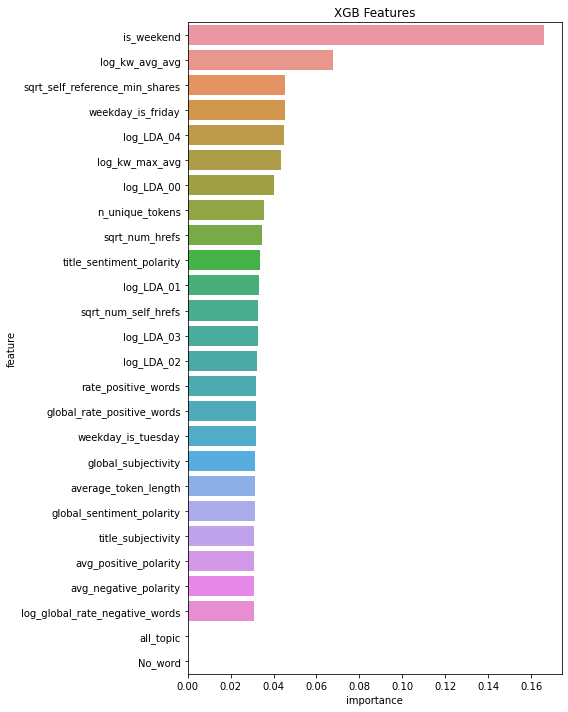

In [88]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGB Features')
    plt.tight_layout()
    plt.savefig('XGB feature impt 26 selected features ')
display_importances(feature_importance_df)

In [87]:
feature_importance_df

,feature,importance
0,is_weekend,0.165930
1,log_kw_avg_avg,0.067677
2,sqrt_self_reference_min_shares,0.045381
3,weekday_is_friday,0.045237
4,log_LDA_04,0.044913
5,log_kw_max_avg,0.043312
6,log_LDA_00,0.039996
7,n_unique_tokens,0.035459
8,sqrt_num_hrefs,0.034720
9,title_sentiment_polarity,0.033582


## Feature selection

In [64]:
feature_0 = feature_importance_df.feature[0]
xgb_clf.fit(X_train[[feature_0]], y_train)
score_0 = accuracy_score(y_test, xgb_clf.predict(X_test[[feature_0]]))

features = [feature_0]
scores = [score_0]

for feature in feature_importance_df.feature[1:]:
    features_temp = features.copy()
    features_temp.append(feature)
    xgb_clf.fit(X_train[features_temp], y_train)
    score = accuracy_score(y_test, xgb_clf.predict(X_test[features_temp]))
    if score > max(scores):
        features.append(feature)
        scores.append(score)
print('number of features: ', len(features))
print(features)
print(scores)

number of features:  13
['is_weekend', 'log_kw_avg_avg', 'sqrt_self_reference_min_shares', 'log_LDA_04', 'log_kw_max_avg', 'log_LDA_00', 'n_unique_tokens', 'sqrt_num_hrefs', 'log_LDA_03', 'log_LDA_02', 'rate_positive_words', 'average_token_length', 'avg_positive_polarity']
[0.38993797381116474, 0.3988973121984838, 0.4100620261888353, 0.41557546519641625, 0.4181943487250172, 0.42908339076498964, 0.44148862853204685, 0.44176430048242593, 0.44493452791178495, 0.44521019986216404, 0.4474155754651964, 0.447829083390765, 0.4500344589937974]


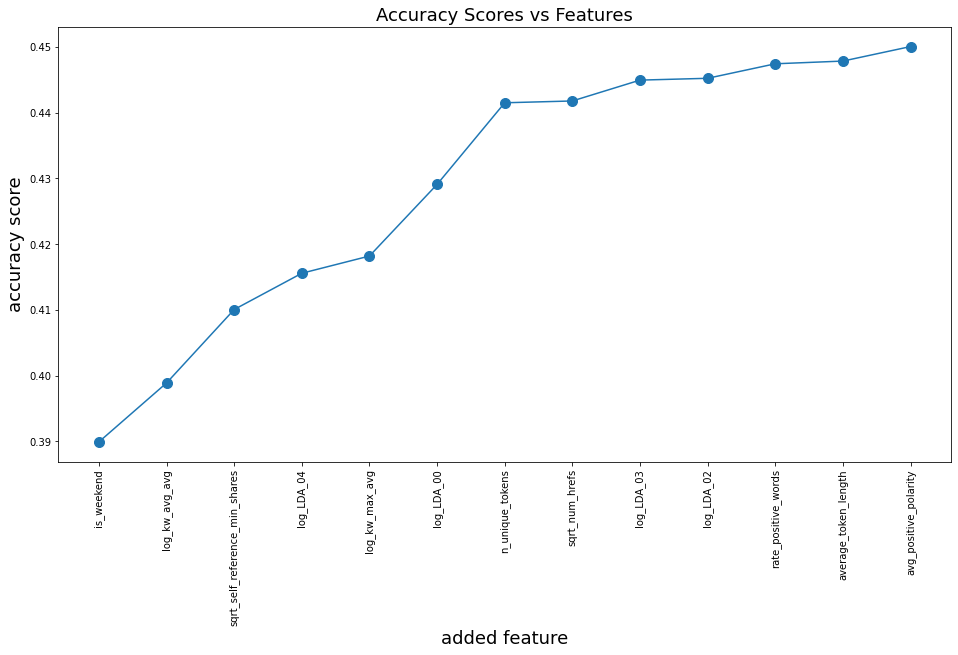

In [66]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(range(len(features)), scores, marker = '.', markersize = 20)
ax.set_title("Accuracy Scores vs Features", fontsize=18)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features,rotation=90)
ax.set_xlabel("added feature", fontsize=18)
ax.set_ylabel("accuracy score", fontsize=18)
plt.savefig('xgb accuracy scores')

## Final resut

In [67]:
len(features)

13

In [68]:
X_train = X_train[features]
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

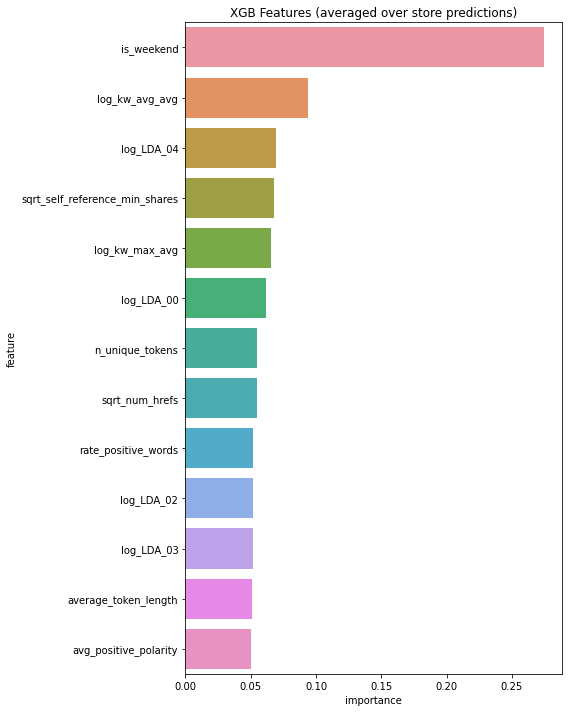

In [69]:
model = xgb_clf

model.fit(X_train, y_train)

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = features
feature_importance_df["importance"] = model.feature_importances_

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGB Features (averaged over store predictions)')
    plt.tight_layout()
    plt.savefig('XGB feature impt 13 optimal features ')
display_importances(feature_importance_df)

In [70]:
y_pred = model.predict(X_test[features])
report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test[features]), multi_class='ovr')
accuracy = accuracy_score(y_test, y_pred)
print(report)
print('auc: ', auc)
print('accuracy: ', accuracy)

              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2252
           1       0.44      0.61      0.51      2829
           2       0.40      0.20      0.26      1599
           3       0.23      0.05      0.08       575

    accuracy                           0.45      7255
   macro avg       0.39      0.35      0.34      7255
weighted avg       0.43      0.45      0.42      7255

auc:  0.6627588034546997
accuracy:  0.4500344589937974
